# Alignment Analysis Starter Notebook

This notebook provides a guided starting point for exploring alignment metrics in `data/outputs/merged.csv`.

Goals:
- Inspect the dataset schema and basic quality checks.
- Explore semantic, sentiment, and LSM alignment distributions.
- Compare alignment by direction and conversation metadata.
- Examine topic-conditioned alignment patterns.


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Palette sampled from the project figure: blue (A), green (B), orange (C)
BLUE = '#4F80C0'
GREEN = '#1C7147'
ORANGE = '#DC5C35'

METRIC_COLORS = {
    'semantic_similarity': ORANGE,
    'sentiment_similarity': BLUE,
    'lsm_score': GREEN,
}

sns.set_theme(style='whitegrid')
sns.set_palette([BLUE, GREEN, ORANGE])


## Load data


In [2]:
path = '../../data/outputs/merged.csv'
df = pd.read_csv(path)
df.head()


,conv_id,title,turn,n_tokens_total,user_cross_check_5,assistant_cross_check_5,author,subreddit,has_custom_instructions,custom_gpt_used,...,user_topic_id,user_topic_score,user_keywords,assistant_topic_id,assistant_topic_score,assistant_keywords,combined_topic_id,combined_topic_score,combined_keywords,combined_cross_check_5
0,69337716-6590-8012-b3fe-2c0a28192de6,Songhai-model creation,1,375,creat,Below,Adventurous_Rate7118,AgentTheory,True,True,...,13.0,0.155235,data / systems / architecture / model / design...,17.0,0.100960,architecture / agent / agents / structured / s...,16.0,0.126386,architecture / agent / agents / framework / sy...,creat
1,693343d7-a38c-8012-a67c-11cbed4c0fd9,Unified theory of agent,1,914,synth,Below,Adventurous_Rate7118,AgentTheory,True,True,...,24.0,0.403624,theory / agent / unified / model / entity / ch...,17.0,0.420432,architecture / agent / agents / structured / s...,16.0,0.475564,architecture / agent / agents / framework / sy...,synth
2,693343d7-a38c-8012-a67c-11cbed4c0fd9,Unified theory of agent,-1,903,produ,Below,Adventurous_Rate7118,AgentTheory,True,True,...,24.0,0.403624,theory / agent / unified / model / entity / ch...,17.0,0.420432,architecture / agent / agents / structured / s...,16.0,0.475564,architecture / agent / agents / framework / sy...,synth
3,693343d7-a38c-8012-a67c-11cbed4c0fd9,Unified theory of agent,2,928,produ,Under,Adventurous_Rate7118,AgentTheory,True,True,...,24.0,0.403624,theory / agent / unified / model / entity / ch...,17.0,0.420432,architecture / agent / agents / structured / s...,16.0,0.475564,architecture / agent / agents / framework / sy...,synth
4,693343d7-a38c-8012-a67c-11cbed4c0fd9,Unified theory of agent,-2,928,Produ,Under,Adventurous_Rate7118,AgentTheory,True,True,...,24.0,0.403624,theory / agent / unified / model / entity / ch...,17.0,0.420432,architecture / agent / agents / structured / s...,16.0,0.475564,architecture / agent / agents / framework / sy...,synth


## Basic schema and missingness


In [3]:
df.shape

(75203, 29)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75203 entries, 0 to 75202
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conv_id                  75203 non-null  object 
 1   title                    75175 non-null  object 
 2   turn                     75203 non-null  int64  
 3   n_tokens_total           75203 non-null  int64  
 4   user_cross_check_5       75203 non-null  object 
 5   assistant_cross_check_5  75203 non-null  object 
 6   author                   75203 non-null  object 
 7   subreddit                75203 non-null  object 
 8   has_custom_instructions  67277 non-null  object 
 9   custom_gpt_used          5530 non-null   object 
 10  model_slug               73657 non-null  object 
 11  has_reasoning            14748 non-null  object 
 12  tools_used               50694 non-null  object 
 13  direction                75203 non-null  object 
 14  user_message_id       

In [47]:
# make conv id and title character type
df['conv_id'] = df['conv_id'].astype(str)
df['title'] = df['title'].astype(str)
df['turn'] = df['turn'].astype(int)

# convert missing values into false
missing = df.isna().mean().sort_values(ascending=False)
missing.head(10)


custom_gpt_used                0.926466
tools_used                     0.325905
has_custom_instructions        0.105395
semantic_similarity            0.039746
sentiment_similarity_z         0.039746
sentiment_similarity_minmax    0.039746
sentiment_similarity           0.039746
semantic_similarity_minmax     0.039746
semantic_similarity_z          0.039746
model_slug                     0.020558
dtype: float64

## Alignment metric distributions


In [6]:
metrics = ['semantic_similarity', 'sentiment_similarity', 'lsm_score']
df[metrics].describe().T


,count,mean,std,min,25%,50%,75%,max
semantic_similarity,72214.0,0.389943,0.246799,-1.808163e-01,0.177477,0.381130,0.595392,1.0
sentiment_similarity,72214.0,0.588573,0.455426,1.722574e-04,0.031128,0.925181,0.996133,1.0
lsm_score,75203.0,0.419389,0.236956,8.285713e-08,0.237061,0.428571,0.595680,1.0


## Normalize alignment scores
We compute both z-scores and min-max scaled versions per metric for easier comparison.


In [7]:
# Z-score normalization per metric
for metric in metrics:
    mean = df[metric].mean()
    std = df[metric].std()
    df[f'{metric}_z'] = (df[metric] - mean) / std

# Min-max normalization per metric
for metric in metrics:
    min_val = df[metric].min()
    max_val = df[metric].max()
    df[f'{metric}_minmax'] = (df[metric] - min_val) / (max_val - min_val)

norm_cols = [f'{m}_z' for m in metrics] + [f'{m}_minmax' for m in metrics]
df[norm_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
semantic_similarity_z,72214.0,-8.816106e-17,1.000000,-2.312647,-0.860887,-0.035706,0.832457,2.471879
sentiment_similarity_z,72214.0,-9.760689e-17,1.000000,-1.291978,-1.224006,0.739106,0.894898,0.903390
lsm_score_z,75203.0,2.539711e-16,1.000000,-1.769902,-0.769459,0.038750,0.743977,2.450285
semantic_similarity_minmax,72214.0,4.833597e-01,0.209007,0.000000,0.303428,0.475897,0.657349,1.000000
sentiment_similarity_minmax,72214.0,5.885017e-01,0.455505,0.000000,0.030962,0.925168,0.996132,1.000000
lsm_score_minmax,75203.0,4.193894e-01,0.236956,0.000000,0.237061,0.428571,0.595680,1.000000


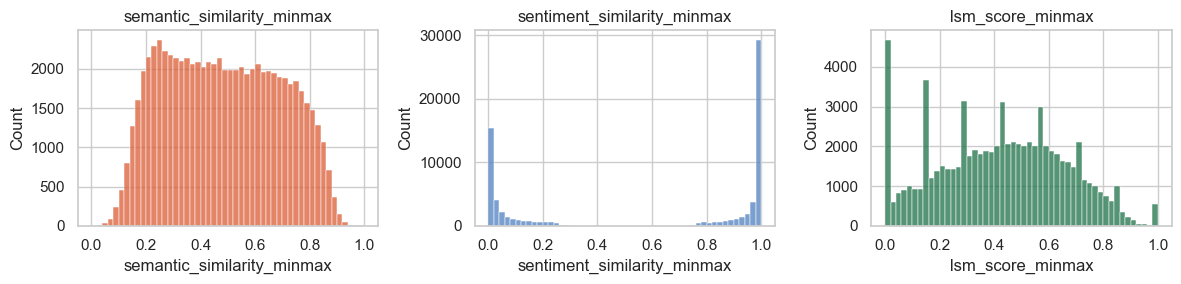

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, metric in zip(axes, metrics):
    col = f'{metric}_minmax'
    sns.histplot(df[col].dropna(), bins=50, color=METRIC_COLORS[metric], ax=ax)
    ax.set_title(col)
plt.tight_layout()

## Alignment by direction


C:\Users\szh\AppData\Local\Temp\ipykernel_39844\4235857457.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='direction', y=col, palette=direction_palette)


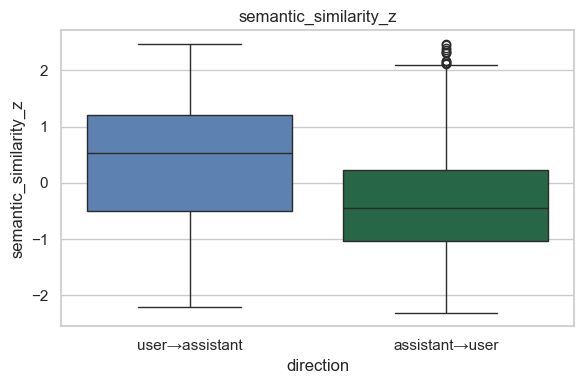

C:\Users\szh\AppData\Local\Temp\ipykernel_39844\4235857457.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='direction', y=col, palette=direction_palette)


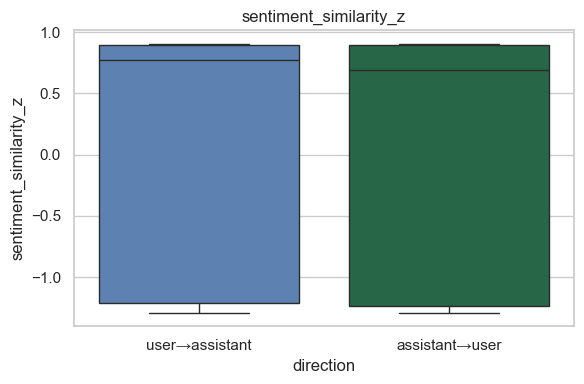

C:\Users\szh\AppData\Local\Temp\ipykernel_39844\4235857457.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='direction', y=col, palette=direction_palette)


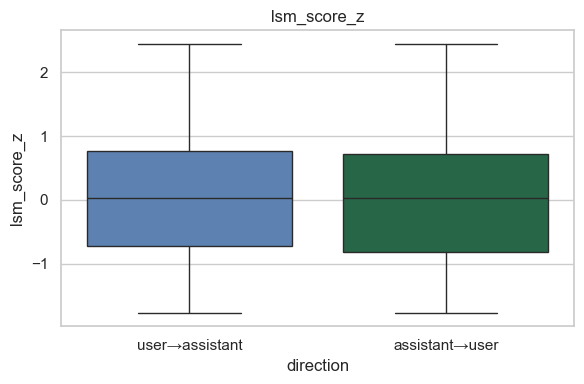

In [9]:
direction_palette = [BLUE, GREEN]
for metric in metrics:
    plt.figure(figsize=(6, 4))
    col = f'{metric}_z'
    sns.boxplot(data=df, x='direction', y=col, palette=direction_palette)
    plt.title(col)
    plt.tight_layout()
    plt.show()


## Alignment vs. message length


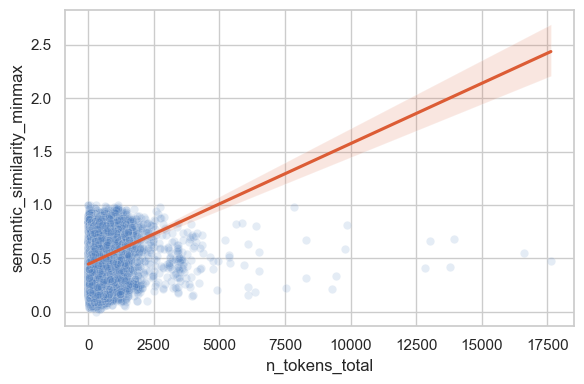

In [33]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='n_tokens_total', y='semantic_similarity_minmax', alpha=0.15, color=BLUE)
sns.regplot(data=df, x='n_tokens_total', y='semantic_similarity_minmax', scatter=False, color=ORANGE)
plt.tight_layout()

## Metadata slices (model, tools, reasoning)


C:\Users\szh\AppData\Local\Temp\ipykernel_39844\2838919734.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['has_reasoning'] = df['has_reasoning'].fillna(False)
C:\Users\szh\AppData\Local\Temp\ipykernel_39844\2838919734.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='has_reasoning', y='semantic_similarity_z', palette=[BLUE, ORANGE])


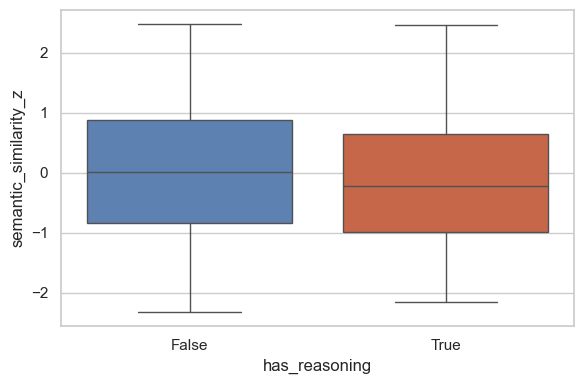

In [11]:
df['has_reasoning'] = df['has_reasoning'].fillna(False)
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='has_reasoning', y='semantic_similarity_z', palette=[BLUE, ORANGE])
plt.tight_layout()


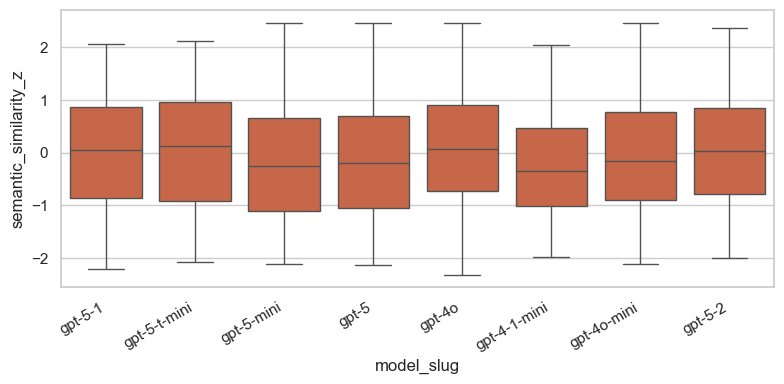

In [12]:
top_models = df['model_slug'].value_counts().head(8).index
plt.figure(figsize=(8, 4))
sns.boxplot(data=df[df['model_slug'].isin(top_models)], x='model_slug', y='semantic_similarity_z', color=ORANGE)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()


## Topic-conditioned alignment


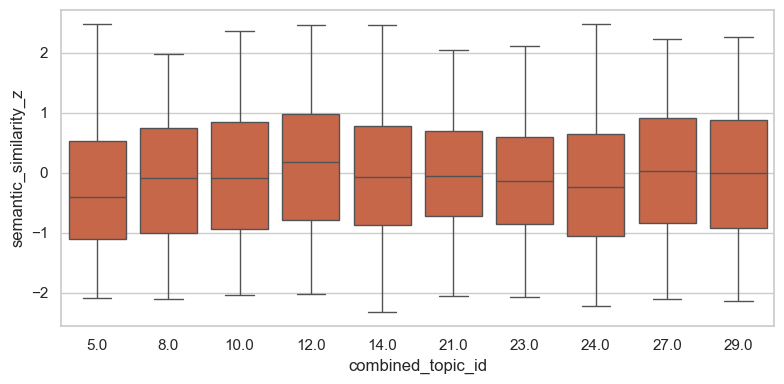

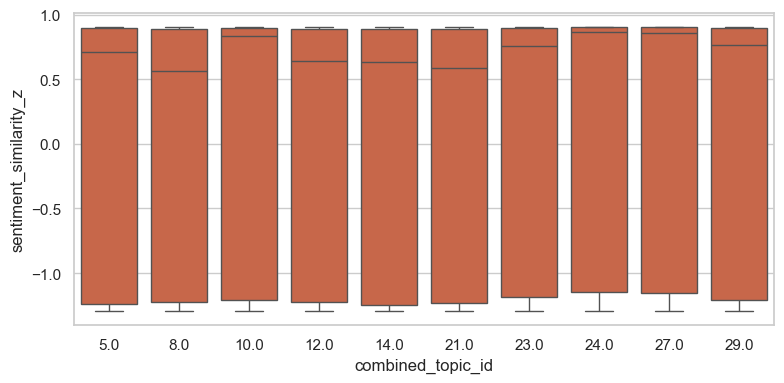

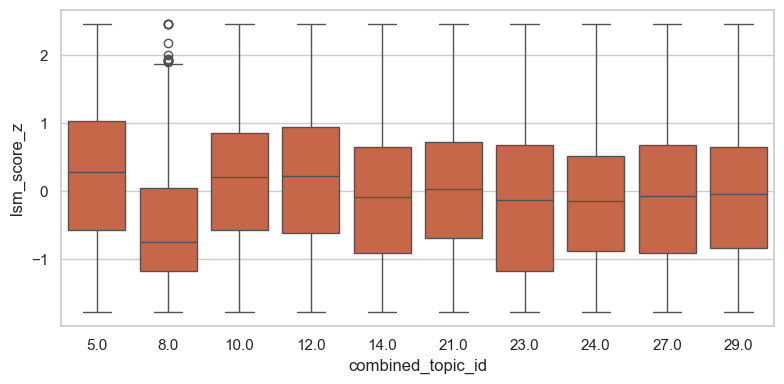

In [45]:
top_topics = df['combined_topic_id'].value_counts().head(10).index
plt.figure(figsize=(8, 4))
sns.boxplot(data=df[df['combined_topic_id'].isin(top_topics)], x='combined_topic_id', y='semantic_similarity_z', color=ORANGE)
plt.tight_layout()


top_topics = df['combined_topic_id'].value_counts().head(10).index
plt.figure(figsize=(8, 4))
sns.boxplot(data=df[df['combined_topic_id'].isin(top_topics)], x='combined_topic_id', y='sentiment_similarity_z', color=ORANGE)
plt.tight_layout()

top_topics = df['combined_topic_id'].value_counts().head(10).index
plt.figure(figsize=(8, 4))
sns.boxplot(data=df[df['combined_topic_id'].isin(top_topics)], x='combined_topic_id', y='lsm_score_z', color=ORANGE)
plt.tight_layout()


## Topic alignment by model and customization flags
Compare topic-conditioned alignment across model, custom instructions, and custom GPT usage.


C:\Users\szh\AppData\Local\Temp\ipykernel_39844\4168255815.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  topic_df['has_custom_instructions'] = topic_df['has_custom_instructions'].fillna(False)
C:\Users\szh\AppData\Local\Temp\ipykernel_39844\4168255815.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  topic_df['custom_gpt_used'] = topic_df['custom_gpt_used'].fillna(False)


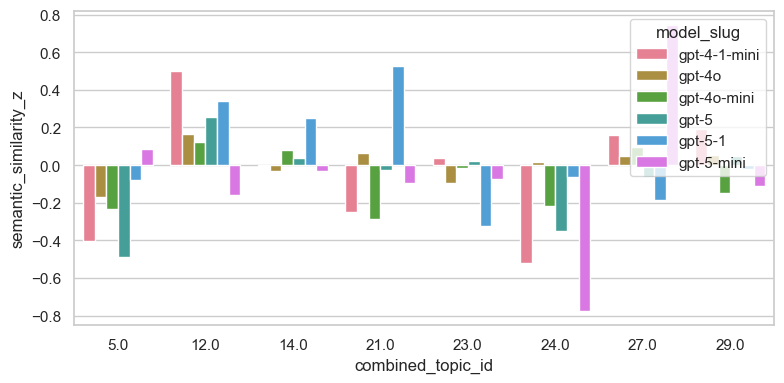

In [14]:
# Focus on top topics for stability
top_topics = df['combined_topic_id'].value_counts().head(8).index
topic_df = df[df['combined_topic_id'].isin(top_topics)].copy()

# Ensure booleans are filled
topic_df['has_custom_instructions'] = topic_df['has_custom_instructions'].fillna(False)
topic_df['custom_gpt_used'] = topic_df['custom_gpt_used'].fillna(False)

# Topic x model (top models only)
top_models = topic_df['model_slug'].value_counts().head(6).index
pivot = (topic_df[topic_df['model_slug'].isin(top_models)]
         .groupby(['combined_topic_id', 'model_slug'])['semantic_similarity_z']
         .mean()
         .reset_index())
plt.figure(figsize=(8, 4))
sns.barplot(data=pivot, x='combined_topic_id', y='semantic_similarity_z', hue='model_slug')
plt.tight_layout()


C:\Users\szh\AppData\Local\Temp\ipykernel_39844\1017717103.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  topic_df['has_custom_instructions'] = topic_df['has_custom_instructions'].fillna(False)
C:\Users\szh\AppData\Local\Temp\ipykernel_39844\1017717103.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  topic_df['custom_gpt_used'] = topic_df['custom_gpt_used'].fillna(False)


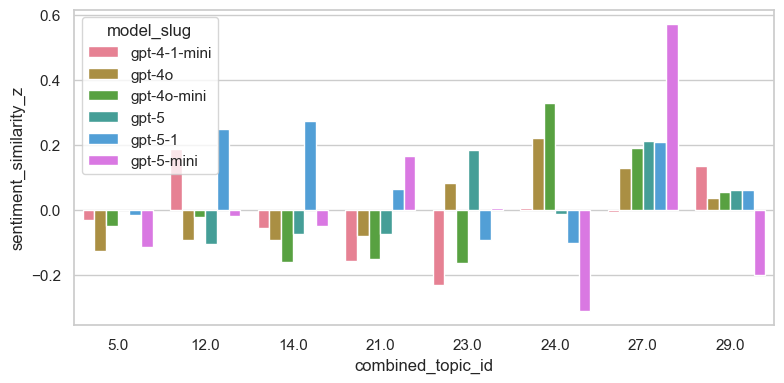

In [34]:
# Focus on top topics for stability
top_topics = df['combined_topic_id'].value_counts().head(8).index
topic_df = df[df['combined_topic_id'].isin(top_topics)].copy()

# Ensure booleans are filled
topic_df['has_custom_instructions'] = topic_df['has_custom_instructions'].fillna(False)
topic_df['custom_gpt_used'] = topic_df['custom_gpt_used'].fillna(False)

# Topic x model (top models only)
top_models = topic_df['model_slug'].value_counts().head(6).index
pivot = (topic_df[topic_df['model_slug'].isin(top_models)]
         .groupby(['combined_topic_id', 'model_slug'])['sentiment_similarity_z']
         .mean()
         .reset_index())
plt.figure(figsize=(8, 4))
sns.barplot(data=pivot, x='combined_topic_id', y='sentiment_similarity_z', hue='model_slug')
plt.tight_layout()


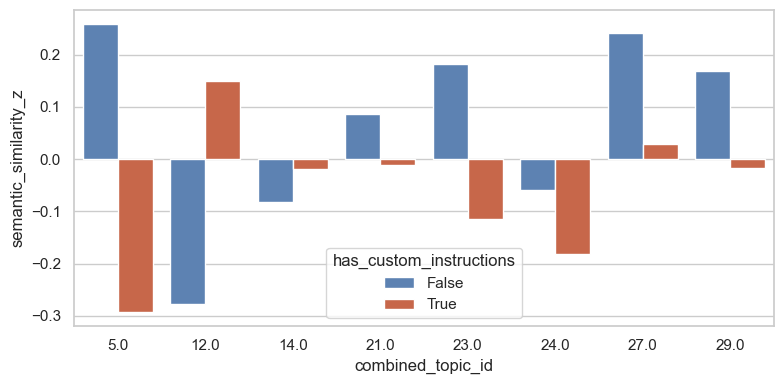

In [15]:
# Topic x custom instructions
pivot_ci = (topic_df
           .groupby(['combined_topic_id', 'has_custom_instructions'])['semantic_similarity_z']
           .mean()
           .reset_index())
plt.figure(figsize=(8, 4))
sns.barplot(data=pivot_ci, x='combined_topic_id', y='semantic_similarity_z', hue='has_custom_instructions',
            palette=[BLUE, ORANGE])
plt.tight_layout()


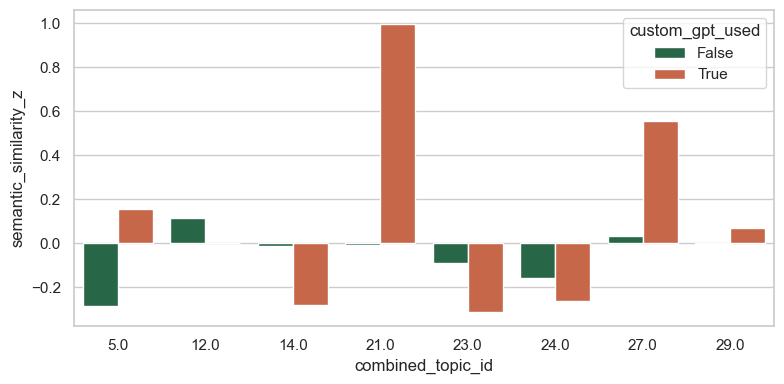

In [16]:
# Topic x custom GPT usage
pivot_cg = (topic_df
           .groupby(['combined_topic_id', 'custom_gpt_used'])['semantic_similarity_z']
           .mean()
           .reset_index())
plt.figure(figsize=(8, 4))
sns.barplot(data=pivot_cg, x='combined_topic_id', y='semantic_similarity_z', hue='custom_gpt_used',
            palette=[GREEN, ORANGE])
plt.tight_layout()


## Topic exploration
Inspect dominant topics and their keywords.


In [17]:
topic_counts = df['combined_topic_id'].value_counts().head(12)
topic_counts


combined_topic_id
14.0    6016
24.0    5503
5.0     4696
27.0    4688
29.0    4433
23.0    4403
21.0    4044
12.0    3263
10.0    2908
8.0     2800
9.0     2645
13.0    2625
Name: count, dtype: int64

In [18]:
topic_keywords = (df[['combined_topic_id', 'combined_keywords']]
                  .dropna()
                  .drop_duplicates()
                  .set_index('combined_topic_id')
                  .loc[topic_counts.index])
topic_keywords


,combined_keywords
combined_topic_id,
14.0,character / writing / characters / rhythm / wr...
24.0,programming / basics / learning / basic / pyth...
5.0,conversation / conversations / chat / talk / t...
27.0,gpu / hardware / performance / cpu / blockchai...
29.0,diet / foods / nutrition / dietary / food / me...
23.0,spiritual / spirituality / meditation / soul /...
21.0,evolution / nature / evolutionary / humanity /...
12.0,universe / cosmic / cosmology / spacetime / co...
10.0,financial / market / investment / finance / ma...


## User vs assistant topic keyword similarity
Compare user and assistant topics via keyword overlap (Jaccard).


In [19]:
def keyword_set(s):
    if pd.isna(s):
        return set()
    return {w.strip() for w in str(s).split('/') if w.strip()}

def jaccard(a, b):
    if not a and not b:
        return np.nan
    return len(a & b) / len(a | b)

df['user_kw_set'] = df['user_keywords'].apply(keyword_set)
df['assistant_kw_set'] = df['assistant_keywords'].apply(keyword_set)
df['ua_keyword_jaccard'] = [
    jaccard(u, a) for u, a in zip(df['user_kw_set'], df['assistant_kw_set'])
]

df['ua_keyword_jaccard'].describe()


count    75124.000000
mean         0.069339
std          0.131714
min          0.000000
25%          0.000000
50%          0.000000
75%          0.125000
max          0.500000
Name: ua_keyword_jaccard, dtype: float64

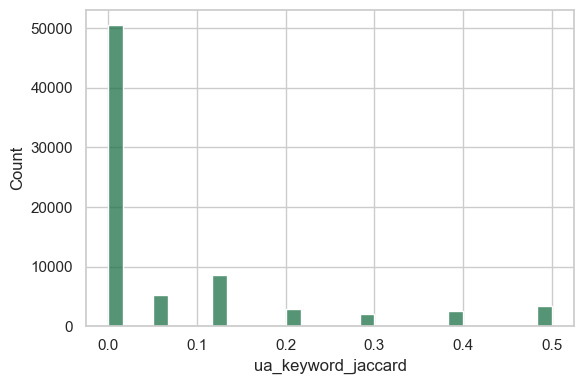

In [20]:
plt.figure(figsize=(6, 4))
sns.histplot(df['ua_keyword_jaccard'].dropna(), bins=30, color=GREEN)
plt.tight_layout()


### Keyword overlap examples
Inspect example rows with explicit overlap between user and assistant topic keywords.


In [21]:
def kw_overlap(u, a):
    overlap = sorted(u & a)
    return ', '.join(overlap)

df['ua_keyword_overlap'] = [
    kw_overlap(u, a) for u, a in zip(df['user_kw_set'], df['assistant_kw_set'])
]

cols = [
    'user_topic_id', 'assistant_topic_id',
    'user_keywords', 'assistant_keywords',
    'ua_keyword_overlap', 'ua_keyword_jaccard'
]

df[cols].sort_values('ua_keyword_jaccard', ascending=False).head(15)


,user_topic_id,assistant_topic_id,user_keywords,assistant_keywords,ua_keyword_overlap,ua_keyword_jaccard
14331,5.0,11.0,universe / space / cosmic / spacetime / quantu...,universe / cosmic / cosmology / spacetime / co...,"cosmic, cosmology, space, spacetime, universe,...",0.5
5626,8.0,16.0,consciousness / conscious / self / awareness /...,consciousness / conscious / awareness / self /...,"awareness, brain, conscious, consciousness, pe...",0.5
5625,8.0,16.0,consciousness / conscious / self / awareness /...,consciousness / conscious / awareness / self /...,"awareness, brain, conscious, consciousness, pe...",0.5
28656,7.0,5.0,feel / feeling / felt / talk / self / feels / ...,feel / feeling / emotional / felt / self / emo...,"emotional, feel, feeling, feels, felt, self",0.5
28655,7.0,5.0,feel / feeling / felt / talk / self / feels / ...,feel / feeling / emotional / felt / self / emo...,"emotional, feel, feeling, feels, felt, self",0.5
28654,7.0,5.0,feel / feeling / felt / talk / self / feels / ...,feel / feeling / emotional / felt / self / emo...,"emotional, feel, feeling, feels, felt, self",0.5
28653,7.0,5.0,feel / feeling / felt / talk / self / feels / ...,feel / feeling / emotional / felt / self / emo...,"emotional, feel, feeling, feels, felt, self",0.5
28652,7.0,5.0,feel / feeling / felt / talk / self / feels / ...,feel / feeling / emotional / felt / self / emo...,"emotional, feel, feeling, feels, felt, self",0.5
28651,7.0,5.0,feel / feeling / felt / talk / self / feels / ...,feel / feeling / emotional / felt / self / emo...,"emotional, feel, feeling, feels, felt, self",0.5
28650,7.0,5.0,feel / feeling / felt / talk / self / feels / ...,feel / feeling / emotional / felt / self / emo...,"emotional, feel, feeling, feels, felt, self",0.5


### Unique topic-pair overview
Deduplicate to show each user/assistant topic pairing once, with overlap and frequency.


In [22]:
pair_cols = [
    'user_topic_id', 'assistant_topic_id',
    'user_keywords', 'assistant_keywords',
    'ua_keyword_overlap', 'ua_keyword_jaccard'
]

pairs = (df[pair_cols]
         .drop_duplicates()
         .merge(
             df.groupby(['user_topic_id', 'assistant_topic_id'])
               .size()
               .rename('pair_count')
               .reset_index(),
             on=['user_topic_id', 'assistant_topic_id'],
             how='left'
         )
         .sort_values('pair_count', ascending=False))

pairs.head(25)


,user_topic_id,assistant_topic_id,user_keywords,assistant_keywords,ua_keyword_overlap,ua_keyword_jaccard,pair_count
69,13.0,15.0,data / systems / architecture / model / design...,programming / tools / code / basic / python / ...,"learning, software",0.125000,2755.0
100,27.0,27.0,make / image / video / want / time / just / li...,rhythm / resonance / resonate / music / tone /...,,0.000000,2128.0
111,27.0,14.0,make / image / video / want / time / just / li...,image / design / style / creative / art / imag...,"image, images",0.125000,1645.0
61,5.0,11.0,universe / space / cosmic / spacetime / quantu...,universe / cosmic / cosmology / spacetime / co...,"cosmic, cosmology, space, spacetime, universe,...",0.500000,1620.0
81,20.0,8.0,chat / gpt / talk / chats / messages / openai ...,conversation / conversations / chatgpt / chat ...,"chat, openai, talk",0.200000,1515.0
82,25.0,23.0,earth / nature / planet / humanity / sun / oce...,evolution / evolutionary / biological / nature...,"humanity, nature",0.125000,1064.0
42,29.0,20.0,trump / donald / president / 2025 / election /...,trump / presidential / donald / election / fed...,"donald, election, president, presidential, trump",0.384615,994.0
99,9.0,1.0,political / democracy / politics / politicians...,democracy / political / democratic / governanc...,"democracy, democratic, political, politicians,...",0.384615,959.0
85,27.0,29.0,make / image / video / want / time / just / li...,diet / foods / food / nutrition / meal / dieta...,,0.000000,918.0
45,19.0,10.0,financial / market / economic / wealth / money...,financial / investment / market / markets / fi...,"financial, market, markets",0.200000,909.0


### Topic-pair frequency heatmap
Heatmap of user vs assistant topic pairing counts (top topics).


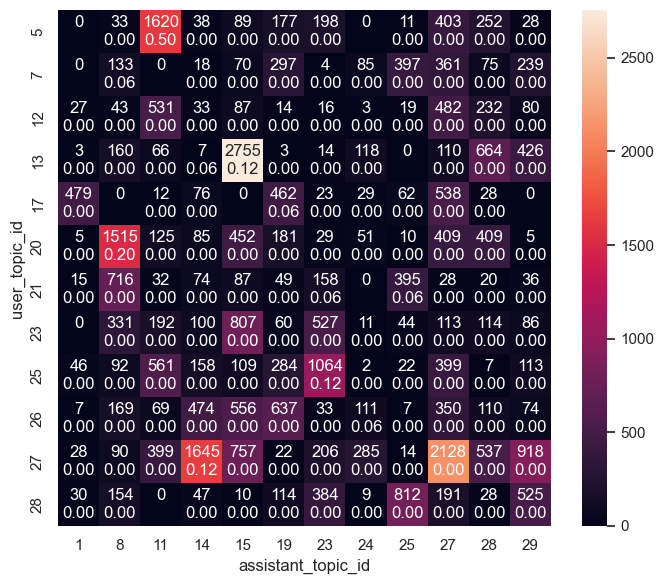

In [39]:
top_user_topics = df['user_topic_id'].value_counts().head(12).index
top_assistant_topics = df['assistant_topic_id'].value_counts().head(12).index
pair_df = df[df['user_topic_id'].isin(top_user_topics) & df['assistant_topic_id'].isin(top_assistant_topics)]
heat = pd.crosstab(pair_df['user_topic_id'], pair_df['assistant_topic_id'])
# Calculate counts and average Jaccard for annotation
counts = heat
# Compute average Jaccard for each topic pair
avg_j = pair_df.groupby(['user_topic_id', 'assistant_topic_id'])['ua_keyword_jaccard'].mean().unstack().reindex(index=top_user_topics, columns=top_assistant_topics)
# Build annotation matrix as DataFrame of strings
annot = pd.DataFrame(index=counts.index, columns=counts.columns)
for i in counts.index:
    for j in counts.columns:
        count_val = counts.loc[i, j] if j in counts.columns else ''
        jaccard_val = avg_j.loc[i, j] if (i in avg_j.index and j in avg_j.columns and pd.notnull(avg_j.loc[i, j])) else ''
        annot.loc[i, j] = f"{count_val}\n{jaccard_val:.2f}" if jaccard_val != '' else f"{count_val}\n"

plt.figure(figsize=(7, 6))
# make color gradient from blue to green to orange
sns.heatmap(heat, annot=annot.values, fmt="", cbar=True)
plt.xlabel('assistant_topic_id')
plt.ylabel('user_topic_id')
plt.tight_layout()

## Subreddit alignment and topics
Compare alignment and topic distributions across subreddits.


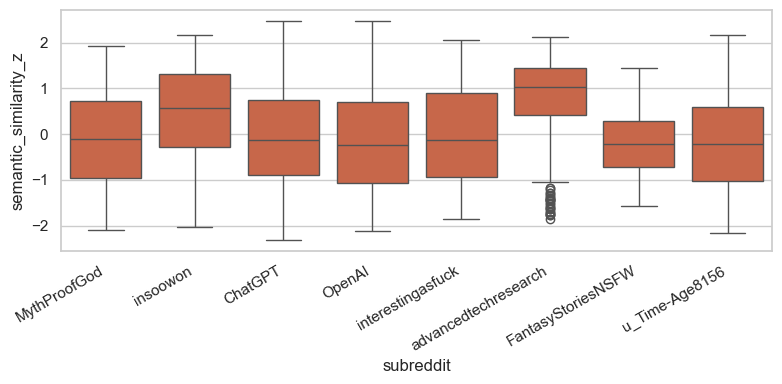

In [24]:
top_subs = df['subreddit'].value_counts().head(8).index
sub_df = df[df['subreddit'].isin(top_subs)]

plt.figure(figsize=(8, 4))
sns.boxplot(data=sub_df, x='subreddit', y='semantic_similarity_z', color=ORANGE)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()


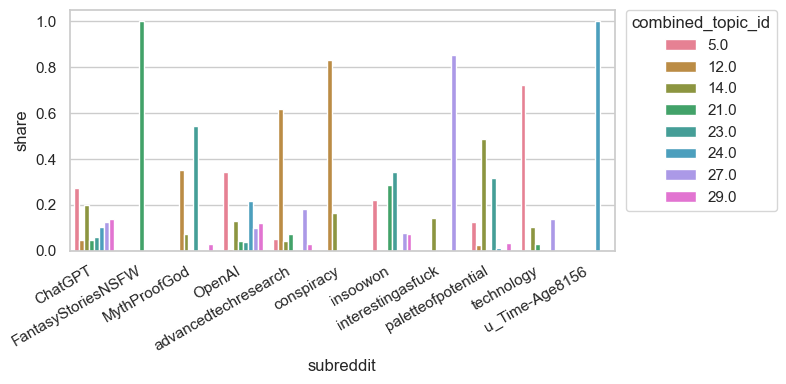

In [ ]:
# Topic mix by subreddit (top topics only)
top_topics = df['combined_topic_id'].value_counts().head(8).index
mix = (df[df['combined_topic_id'].isin(top_topics) & df['subreddit'].isin(top_subs)]
       .groupby(['subreddit', 'combined_topic_id'])
       .size()
       .reset_index(name='count'))

mix['share'] = mix.groupby('subreddit')['count'].transform(lambda s: s / s.sum())

topic_palette = sns.color_palette("husl", n_colors=len(top_topics))

plt.figure(figsize=(8, 4))
ax = sns.barplot(data=mix, x='subreddit', y='share', hue='combined_topic_id', palette=topic_palette)
plt.xticks(rotation=30, ha='right')
ax.legend(title='combined_topic_id', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()


### Subreddit–topic clustering
Cluster subreddits by their topic distributions to see related groups.


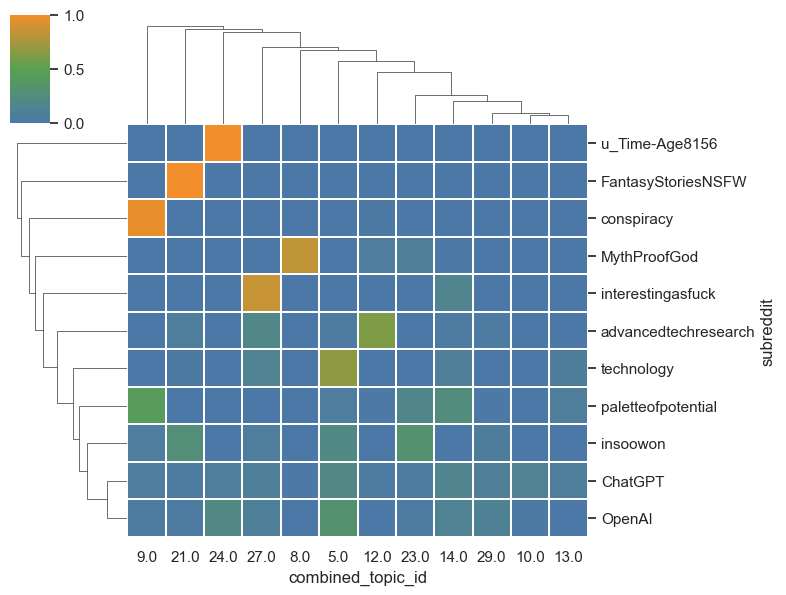

In [26]:
# Build subreddit-topic share matrix (top subreddits/topics)
top_subs = df['subreddit'].value_counts().head(12).index
top_topics = df['combined_topic_id'].value_counts().head(12).index

st = (df[df['subreddit'].isin(top_subs) & df['combined_topic_id'].isin(top_topics)]
      .groupby(['subreddit', 'combined_topic_id'])
      .size()
      .reset_index(name='count'))

st['share'] = st.groupby('subreddit')['count'].transform(lambda s: s / s.sum())
matrix = st.pivot(index='subreddit', columns='combined_topic_id', values='share').fillna(0)

cmap = sns.color_palette('blend:#4C78A8,#59A14F,#F28E2B', as_cmap=True)
sns.clustermap(matrix, cmap=cmap, figsize=(8, 6), linewidths=0.2)


## Quick correlations


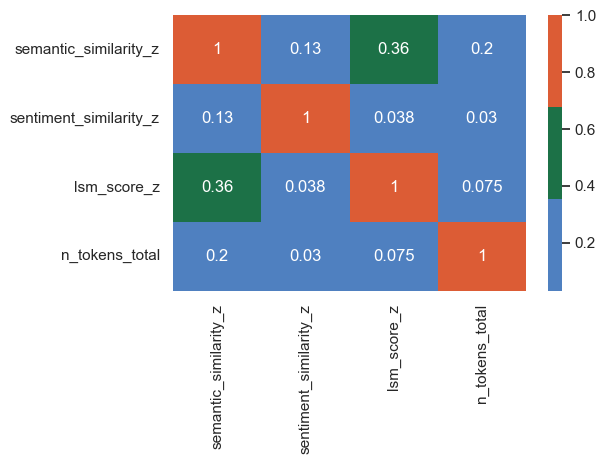

In [27]:
corr = df[[f'{m}_z' for m in metrics] + ['n_tokens_total']].corr()
cmap = sns.color_palette([BLUE, GREEN, ORANGE], as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap)
plt.tight_layout()


C:\Users\szh\AppData\Local\Temp\ipykernel_39844\911592624.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


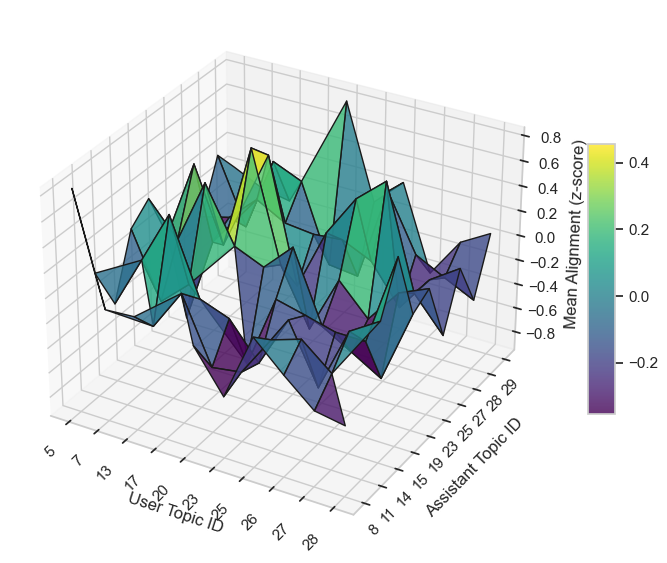

In [31]:
# Ensure topic IDs are integers for plotting
if df['user_topic_id'].dtype != 'int64' and df['user_topic_id'].dtype != 'Int64':
    df['user_topic_id'] = df['user_topic_id'].astype('Int64')
if df['assistant_topic_id'].dtype != 'int64' and df['assistant_topic_id'].dtype != 'Int64':
    df['assistant_topic_id'] = df['assistant_topic_id'].astype('Int64')

# Use the top N most frequent user and assistant topics for clarity
N = 10
top_user_topics = df['user_topic_id'].value_counts().head(N).index
top_assistant_topics = df['assistant_topic_id'].value_counts().head(N).index

filtered = df[df['user_topic_id'].isin(top_user_topics) & df['assistant_topic_id'].isin(top_assistant_topics)]

# Pivot table: mean alignment for each topic pair
pivot = filtered.pivot_table(
    index='user_topic_id',
    columns='assistant_topic_id',
    values='semantic_similarity_z',  # or your metric
    aggfunc='mean'
)

# Prepare meshgrid for plotting
X, Y = np.meshgrid(np.arange(len(pivot.index)), np.arange(len(pivot.columns)))
Z = pivot.values.T  # transpose so axes match

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.8)

ax.set_xticks(np.arange(len(pivot.index)))
ax.set_xticklabels(pivot.index, rotation=45, ha='right')
ax.set_yticks(np.arange(len(pivot.columns)))
ax.set_yticklabels(pivot.columns, rotation=45, ha='right')
ax.set_xlabel('User Topic ID')
ax.set_ylabel('Assistant Topic ID')
ax.set_zlabel('Mean Alignment (z-score)')

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()

In [ ]:
# over time/turns